In [45]:
import pytorch_lightning as pl
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchmetrics import Accuracy

# 定义一个自定义的 Dataset
class MNISTDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        label = self.data.iloc[idx, 0]
        image = self.data.iloc[idx, 1:].values.astype(np.float32)
        
        # 返回一维的像素序列和标签
        return torch.tensor(image), torch.tensor(label)

# 定义一个 LightningDataModule
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='', batch_size=64, num_workers=2):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers

    def setup(self, stage=None):
        # 数据集的定义
        dataset = MNISTDataset(csv_file=self.data_dir + 'train.csv')
        
        # 将数据集划分为训练集和验证集
        train_size = int(0.8 * len(dataset))
        val_size = len(dataset) - train_size
        self.train_dataset, self.val_dataset = random_split(dataset, [train_size, val_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=self.num_workers)



In [46]:
# 初始化数据模块
mnist_dm = MNISTDataModule(data_dir='', batch_size=64)

# 准备数据
mnist_dm.setup()

# 获取一个批次的训练数据
train_loader = mnist_dm.train_dataloader()
batch = next(iter(train_loader))

# 检查批次中的数据维度
images, labels = batch
print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")


Batch of images shape: torch.Size([64, 784])
Batch of labels shape: torch.Size([64])


# 目前：
我们所进行的步骤和`train_seq.ipynb`内的一样。可我们需要将原模型的线性层`nn.Linear`替换为`KANLinear`

```python
class MNISTModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 10)
```
替换为

```python
class MNISTModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.layer_1 = KANLinear(28 * 28, 128)
        self.layer_2 = KANLinear(128, 10)
```

# 首先：
第一次运行，请先git clone对应的repo

你可以clone我汉化和注释过的`efficient-kan`: https://github.com/lgy112112/Efficient-KAN-in-Chinese.git

In [47]:
# !git clone https://github.com/lgy112112/Efficient-KAN-in-Chinese.git # 运行一次之后不需要运行

In [48]:
import sys
sys.path.append('Efficient-KAN-in-Chinese')
# 接着我们可以import内容了
from KAN import *

In [51]:
# 定义模型
class MNISTModel(pl.LightningModule):
    def __init__(self, activation_fn=torch.nn.ReLU):
        super().__init__()
        self.activation_fn = activation_fn  # 通过参数指定激活函数
        self.layer_1 = KANLinear(28 * 28, 128, base_activation=self.activation_fn)
        self.layer_2 = KANLinear(128, 10, base_activation=self.activation_fn)
        self.train_accuracy = Accuracy(task='multiclass', num_classes=10)
        self.val_accuracy = Accuracy(task='multiclass', num_classes=10)
        self.test_accuracy = Accuracy(task='multiclass', num_classes=10)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # 展开图像为一维向量
        x = self.layer_1(x)  # 第一层激活函数在 KANLinear 内部处理
        x = self.layer_2(x)  # 第二层激活函数在 KANLinear 内部处理
        return F.log_softmax(x, dim=1)  # 使用 log_softmax 作为输出

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # 计算准确率
        preds = torch.argmax(logits, dim=1)
        acc = self.train_accuracy(preds, y)
        
        # 记录 loss 和 acc 到进度条
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        
        # 计算准确率
        preds = torch.argmax(logits, dim=1)
        acc = self.val_accuracy(preds, y)
        
        # 记录 loss 和 acc 到进度条
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)  # 使用 Adam 优化器

# 初始化数据模块
mnist_dm = MNISTDataModule(data_dir='', batch_size=64)


# Tanh

In [52]:

# 使用不同的激活函数训练模型
activation_fn = torch.nn.Tanh  # 你可以在这里切换不同的激活函数，例如 torch.nn.ReLU, torch.nn.SiLU, etc.
model = MNISTModel(activation_fn=activation_fn)

# 使用 Trainer 进行训练、验证和测试
trainer = pl.Trainer(max_epochs=10, benchmark=True, deterministic=True)

# 训练模型
trainer.fit(model, mnist_dm)
trainer.validate(datamodule=mnist_dm)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:638: You passed `deterministic=True` and `benchmark=True`. Note that PyTorch ignores torch.backends.cudnn.deterministic=True when torch.backends.cudnn.benchmark=True.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | layer_1        | KANLinear          | 1.0 M  | train
1 | layer_2        | KANLinear          | 12.8 K | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.065     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /teamspace/studios/this_studio/lightning_logs/version_9/checkpoints/epoch=9-step=5250.ckpt
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/lightning_logs/version_9/checkpoints/epoch=9-step=5250.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.991428554058075     │
│         val_loss          │    0.03508393466472626    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.03508393466472626, 'val_acc': 0.991428554058075}]

# SiLU

In [53]:

# 使用不同的激活函数训练模型
activation_fn = torch.nn.SiLU  # 你可以在这里切换不同的激活函数，例如 torch.nn.ReLU, torch.nn.SiLU, etc.
model = MNISTModel(activation_fn=activation_fn)

# 使用 Trainer 进行训练、验证和测试
trainer = pl.Trainer(max_epochs=10, benchmark=True, deterministic=True)

# 训练模型
trainer.fit(model, mnist_dm)
trainer.validate(datamodule=mnist_dm)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:638: You passed `deterministic=True` and `benchmark=True`. Note that PyTorch ignores torch.backends.cudnn.deterministic=True when torch.backends.cudnn.benchmark=True.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | layer_1        | KANLinear          | 1.0 M  | train
1 | layer_2        | KANLinear          | 12.8 K | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.065     Total estimated model params size

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /teamspace/studios/this_studio/lightning_logs/version_10/checkpoints/epoch=9-step=5250.ckpt
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/lightning_logs/version_10/checkpoints/epoch=9-step=5250.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9680952429771423     │
│         val_loss          │     0.112129807472229     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.112129807472229, 'val_acc': 0.9680952429771423}]

# RELU

In [54]:

# 使用不同的激活函数训练模型
activation_fn = torch.nn.ReLU  # 你可以在这里切换不同的激活函数，例如 torch.nn.ReLU, torch.nn.SiLU, etc.
model = MNISTModel(activation_fn=activation_fn)

# 使用 Trainer 进行训练、验证和测试
trainer = pl.Trainer(max_epochs=10, benchmark=True, deterministic=True)

# 训练模型
trainer.fit(model, mnist_dm)
trainer.validate(datamodule=mnist_dm)


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:638: You passed `deterministic=True` and `benchmark=True`. Note that PyTorch ignores torch.backends.cudnn.deterministic=True when torch.backends.cudnn.benchmark=True.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | layer_1        | KANLinear          | 1.0 M  | train
1 | layer_2        | KANLinear          | 12.8 K | train
2 | train_accuracy | MulticlassAccuracy | 0      | train
3 | val_accuracy   | MulticlassAccuracy | 0      | train
4 | test_accuracy  | MulticlassAccuracy | 0      | train
--------------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.065     Total estimated model params size

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:145: `.validate(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.validate(ckpt_path='best')` to use the best model or `.validate(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /teamspace/studios/this_studio/lightning_logs/version_11/checkpoints/epoch=9-step=5250.ckpt
Loaded model weights from the checkpoint at /teamspace/studios/this_studio/lightning_logs/version_11/checkpoints/epoch=9-step=5250.ckpt


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9685714244842529     │
│         val_loss          │    0.1233464851975441     │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.1233464851975441, 'val_acc': 0.9685714244842529}]

---

# 这里
我保存了最近的那一次训练的模型的权重pth，请注意。

然后读取它进行权重的可视化（看个乐子即可）

In [ ]:
torch.save(model.state_dict(), 'mnist_model.pth')


In [ ]:
import torch

# 实例化模型
model = MNISTModel()

# 加载模型权重
model.load_state_dict(torch.load('mnist_model.pth'))

# 将模型切换到评估模式（可选）
model.eval()

# 现在你可以使用模型进行推理或可视化权重


MNISTModel(
  (layer_1): KANLinear(
    (base_activation): GELU(approximate='none')
  )
  (layer_2): KANLinear(
    (base_activation): GELU(approximate='none')
  )
  (train_accuracy): MulticlassAccuracy()
  (val_accuracy): MulticlassAccuracy()
  (test_accuracy): MulticlassAccuracy()
)

In [ ]:
# 检查 KANLinear 类的所有属性
print(vars(model.layer_1))

# 然后使用类似的方法提取权重，替换原始的访问方式。


{'training': False, '_parameters': OrderedDict([('base_weight', Parameter containing:
tensor([[-0.0233,  0.0191, -0.0057,  ..., -0.0328,  0.0021,  0.0136],
        [ 0.0249,  0.0011,  0.0299,  ..., -0.0343, -0.0079, -0.0259],
        [ 0.0076, -0.0118, -0.0129,  ...,  0.0194,  0.0239,  0.0299],
        ...,
        [ 0.0337,  0.0041, -0.0223,  ...,  0.0157, -0.0081, -0.0134],
        [ 0.0350,  0.0206, -0.0002,  ...,  0.0275, -0.0025, -0.0283],
        [ 0.0140,  0.0348,  0.0339,  ..., -0.0039, -0.0255, -0.0280]],
       requires_grad=True)), ('spline_weight', Parameter containing:
tensor([[[ 2.9859e-03,  1.1652e-02, -2.9884e-03,  ..., -2.5192e-02,
           7.8310e-03,  3.5585e-03],
         [ 3.4038e-03,  1.1822e-02, -4.0678e-03,  ...,  4.0574e-03,
           8.0947e-03,  2.3936e-03],
         [-6.2376e-04, -4.7963e-03, -8.6950e-03,  ...,  7.3721e-03,
          -5.4023e-03, -2.0712e-03],
         ...,
         [-3.0451e-04, -5.8205e-04, -4.1865e-03,  ..., -8.4411e-03,
          -7.3

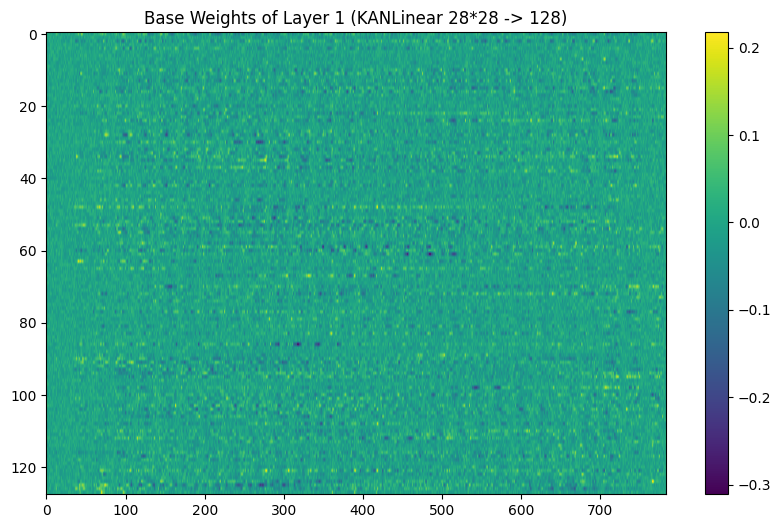

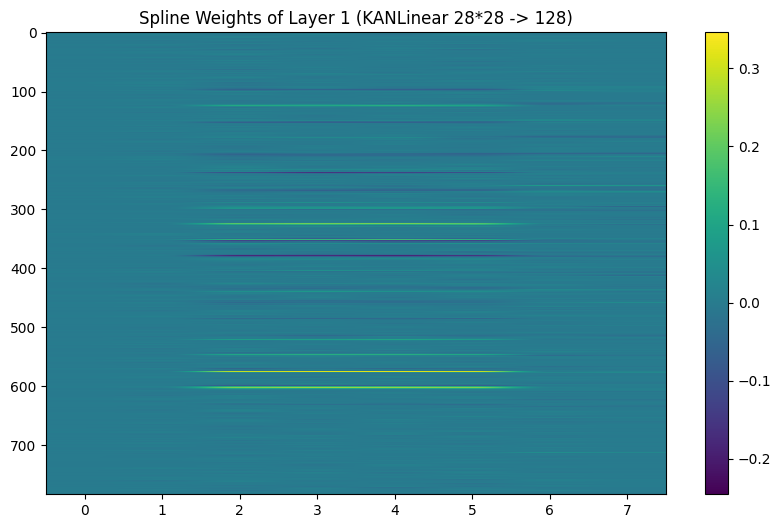

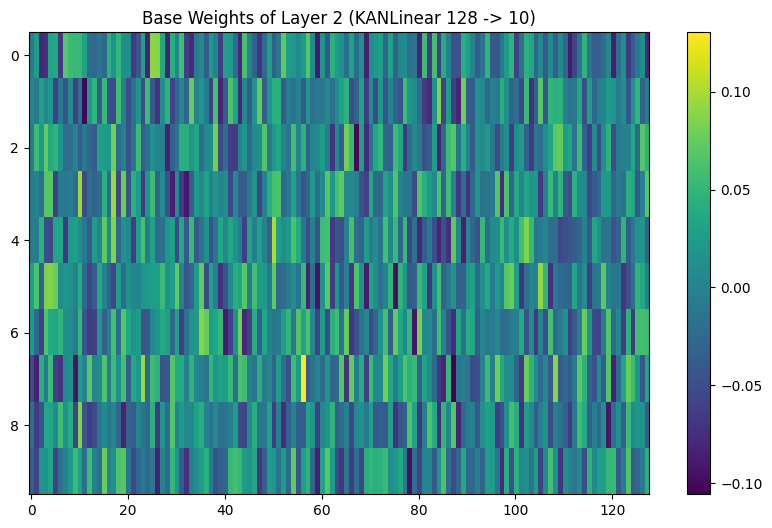

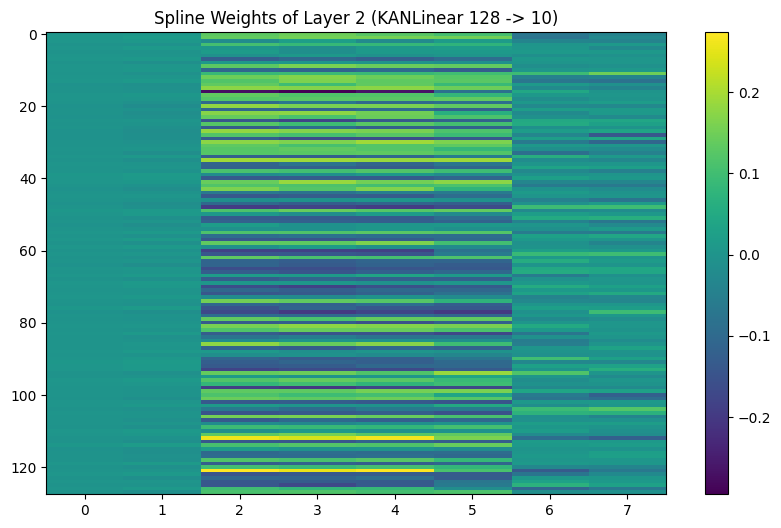

In [ ]:
import matplotlib.pyplot as plt
import torch

# 提取 base_weight 和 spline_weight
base_weight_layer_1 = model.layer_1._parameters['base_weight'].data.cpu().numpy()
spline_weight_layer_1 = model.layer_1._parameters['spline_weight'].data.cpu().numpy()

base_weight_layer_2 = model.layer_2._parameters['base_weight'].data.cpu().numpy()
spline_weight_layer_2 = model.layer_2._parameters['spline_weight'].data.cpu().numpy()

# 可视化第一层的 base_weight
plt.figure(figsize=(10, 6))
plt.title("Base Weights of Layer 1 (KANLinear 28*28 -> 128)")
plt.imshow(base_weight_layer_1, aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()

# 可视化第一层的 spline_weight
plt.figure(figsize=(10, 6))
plt.title("Spline Weights of Layer 1 (KANLinear 28*28 -> 128)")
plt.imshow(spline_weight_layer_1[0], aspect='auto', cmap='viridis')  # 选择一个通道可视化
plt.colorbar()
plt.show()

# 可视化第二层的 base_weight
plt.figure(figsize=(10, 6))
plt.title("Base Weights of Layer 2 (KANLinear 128 -> 10)")
plt.imshow(base_weight_layer_2, aspect='auto', cmap='viridis')
plt.colorbar()
plt.show()

# 可视化第二层的 spline_weight
plt.figure(figsize=(10, 6))
plt.title("Spline Weights of Layer 2 (KANLinear 128 -> 10)")
plt.imshow(spline_weight_layer_2[0], aspect='auto', cmap='viridis')  # 选择一个通道可视化
plt.colorbar()
plt.show()
